# Installing the libraries

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import libraries

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
from google.colab import drive
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 6)

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.constraints import MaxNorm
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint

# Loading the data

In [ ]:
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Incongruence_Data/data_metadata
from utils import *

Mounted at /content/gdrive
/content/gdrive/MyDrive/Incongruence_Data/data_metadata


In [ ]:
df_nike = get_dataframe('nike')
df_gucci = get_dataframe('gucci')
df_cristianoronaldo = get_dataframe('cristianoronaldo')
df_edsheeran = get_dataframe('edsheeran')
df = df_nike.append([df_gucci, df_cristianoronaldo, df_edsheeran])

/content/gdrive/MyDrive/Incongruence_Data/data_metadata/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_post_count'] = pd.to_numeric(df['user_post_count'].values)
/content/gdrive/MyDrive/Incongruence_Data/data_metadata/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_follower_count'] = pd.to_numeric(df['user_follower_count'].values)
/content/gdrive/MyDrive/Incongruence_Data/data_metadata/utils.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [ ]:
# dominant image
# df_nike = get_dominant_image(df_nike)
# df_gucci = get_dominant_image(df_gucci)
# df_cristianoronaldo = get_dominant_image(df_cristianoronaldo)
# df_edsheeran = get_dominant_image(df_edsheeran)

# Analyzing the general charactrisitic of data

In [ ]:
def degree_of_imbalance(dist):
  if dist < 1:
    return 'Extreme'
  elif (dist < 20) and (dist >= 1):
    return 'Moderate'
  elif (dist < 40) and (dist >= 20):
    return 'Mild'
  else:
    return 'Balance'

In [ ]:
# Check whehther the data is imbalanced or not
nike_mismatch_num = len(df_nike[df_nike['class'] == 0].values)
nike_match_num = len(df_nike[df_nike['class'] == 1].values)
gucci_mismatch_num = len(df_gucci[df_gucci['class'] == 0].values)
gucci_match_num = len(df_gucci[df_gucci['class'] == 1].values)
cristianoronaldo_mismatch_num = len(df_cristianoronaldo[df_cristianoronaldo['class'] == 0].values)
cristianoronaldo_match_num = len(df_cristianoronaldo[df_cristianoronaldo['class'] == 1].values)
edsheeran_mismatch_num = len(df_edsheeran[df_edsheeran['class'] == 0].values)
edsheeran_match_num = len(df_edsheeran[df_edsheeran['class'] == 1].values)

all_mismatch_num = len(df[df['class'] == 0].values)
all_match_num = len(df[df['class'] == 1].values)

print('#Nike:')
print(f'{degree_of_imbalance((nike_match_num/nike_mismatch_num)*100)}')
print('*'*10)
print('#Gucci:')
print(f'{degree_of_imbalance((gucci_match_num/gucci_mismatch_num)*100)}')
print('*'*10)
print('#CristianoRonaldo:')
print(f'{degree_of_imbalance((cristianoronaldo_match_num/cristianoronaldo_mismatch_num)*100)}')
print('*'*10)
print('#EdSheeran:')
print(f'{degree_of_imbalance((edsheeran_mismatch_num/edsheeran_match_num)*100)}')

print('*'*10)
print('All datasets:')
print(f'{degree_of_imbalance((all_match_num/all_mismatch_num)*100)}')

#Nike:
Balance
**********
#Gucci:
Balance
**********
#CristianoRonaldo:
Balance
**********
#EdSheeran:
Balance
**********
All datasets:
Balance


In [ ]:
def post_user_count(df):
  return len(df['username'].values), len(set(df['username'].values))

In [ ]:
print('#Nike')
print(f'No. of posts: {post_user_count(df_nike)[0]}, No. of users: {post_user_count(df_nike)[1]}')
print('*'*10)
print('#Gucci')
print(f'No. of posts: {post_user_count(df_gucci)[0]}, No. of users: {post_user_count(df_gucci)[1]}')
print('*'*10)
print('#CristianoRonaldo')
print(f'No. of posts: {post_user_count(df_cristianoronaldo)[0]}, No. of users: {post_user_count(df_cristianoronaldo)[1]}')
print('*'*10)
print('#EdSheeran')
print(f'No. of posts: {post_user_count(df_edsheeran)[0]}, No. of users: {post_user_count(df_edsheeran)[1]}')

#Nike
No. of posts: 3151, No. of users: 2266
**********
#Gucci
No. of posts: 3343, No. of users: 1940
**********
#CristianoRonaldo
No. of posts: 3481, No. of users: 2405
**********
#EdSheeran
No. of posts: 2144, No. of users: 1403


In [ ]:
print('#Nike')
print(f'No. of matches: {df_nike[df_nike["class"] == 1].shape[0]}, No. of mismatches: {df_nike[df_nike["class"] == 0].shape[0]}')
print('*'*10)
print('#Gucci')
print(f'No. of matches: {df_gucci[df_gucci["class"] == 1].shape[0]}, No. of mismatches: {df_gucci[df_gucci["class"] == 0].shape[0]}')
print('*'*10)
print('#CristianoRonaldo')
print(f'No. of matches: {df_cristianoronaldo[df_cristianoronaldo["class"] == 1].shape[0]}, No. of mismatches: {df_cristianoronaldo[df_cristianoronaldo["class"] == 0].shape[0]}')
print('*'*10)
print('#EdSheeran')
print(f'No. of matches: {df_edsheeran[df_edsheeran["class"] == 1].shape[0]}, No. of mismatches: {df_edsheeran[df_edsheeran["class"] == 0].shape[0]}')

# Feature selection

In [ ]:
df.drop(columns=['file_name', 'caption', 'username', 'fullname', 'hashtags',
                 'caption_text_new', 'location_city', 'location_name', 'user_biography',
                'user_business_category', 'caption_text', 'usertag_list'], inplace=True)
df = df.sample(frac=1)
y = df.iloc[:, 7].values
df2 = df.drop(columns=['class'])
X = df2.iloc[:, :].values

In [ ]:
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.478
Model:                            OLS   Adj. R-squared (uncentered):              0.477
Method:                 Least Squares   F-statistic:                              443.7
Date:                Sat, 13 Aug 2022   Prob (F-statistic):                        0.00
Time:                        22:36:17   Log-Likelihood:                         -7548.7
No. Observations:               12119   AIC:                                  1.515e+04
Df Residuals:                   12094   BIC:                                  1.533e+04
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
col = list(df)
sc_x = StandardScaler()
X_sc = sc_x.fit_transform(X)

reg = RandomForestRegressor(n_estimators=50)
reg.fit(X_sc, y)

df_feature_importance = pd.DataFrame(reg.feature_importances_, index=list(df2), columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
hashtags_num,0.199366
user_post_count,0.103186
user_follower_count,0.100009
user_following_count,0.082850
hashtag_sequence_num,0.067510
text_word_count,0.054070
capital_char_num,0.050578
sentiment,0.046734
like_count,0.046077
image_width,0.037400


## Visualizing the feature importance

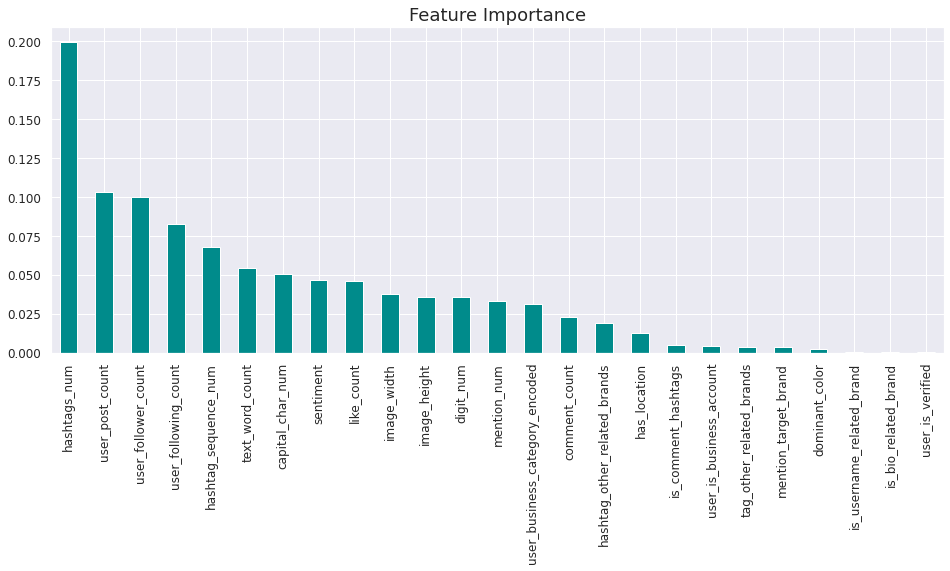

In [ ]:
df_feature_all = pd.DataFrame([tree.feature_importances_ for tree in reg.estimators_], columns=list(df2))
df_feature_long = pd.melt(df_feature_all,var_name='feature name', value_name='values')

df_feature_importance.plot(kind='bar', color='darkcyan', fontsize=12, legend=False)
plt.title('Feature Importance')
plt.savefig('feature_importance.png')

# Features analysis

In [ ]:
colors = ["#c5585b", "#43a071"]
sns.set(font_scale=1.5)
customPalette = sns.set_palette(sns.color_palette(colors))

### Number of hashtag vs. class

([<matplotlib.axis.XTick at 0x7f5a30b25610>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

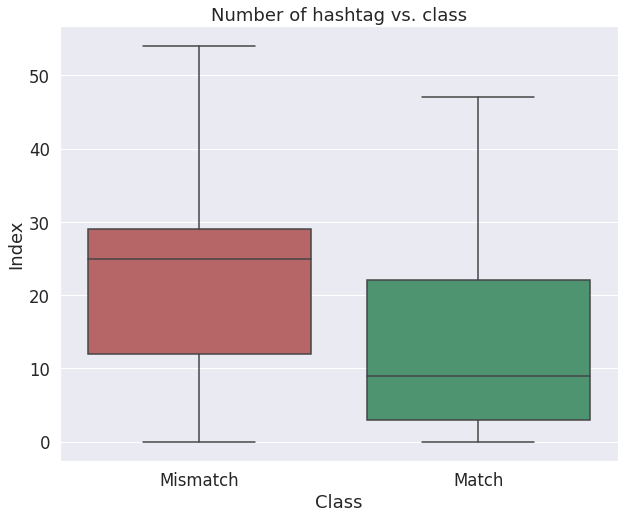

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='hashtags_num',data=df, palette=customPalette, showfliers=False)
plt.title("Number of hashtag vs. class")
plt.xlabel('Class')
plt.ylabel('Index')
plt.xticks([0, 1], ['Mismatch', 'Match'])

### User post count vs. Class

([<matplotlib.axis.XTick at 0x7f5a30d50f10>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

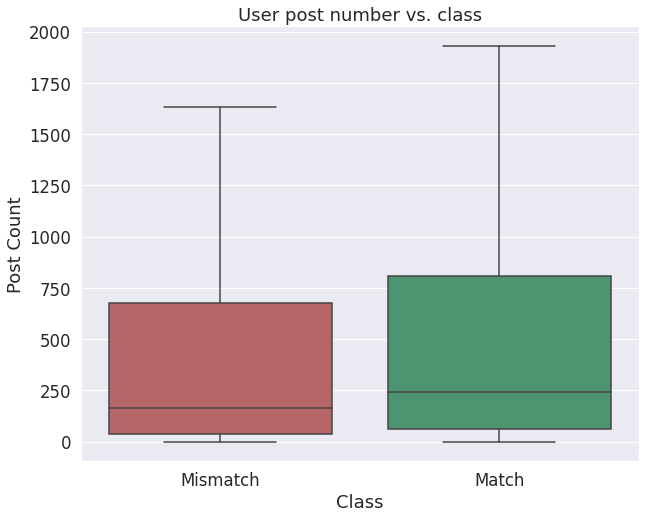

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='user_post_count',data=df, palette=customPalette, showfliers=False)
plt.title("User post number vs. class")
plt.xlabel('Class')
plt.ylabel('Post Count')
plt.xticks([0, 1], ['Mismatch', 'Match'])

### User follower count vs. Class

([<matplotlib.axis.XTick at 0x7f5a31bdb590>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

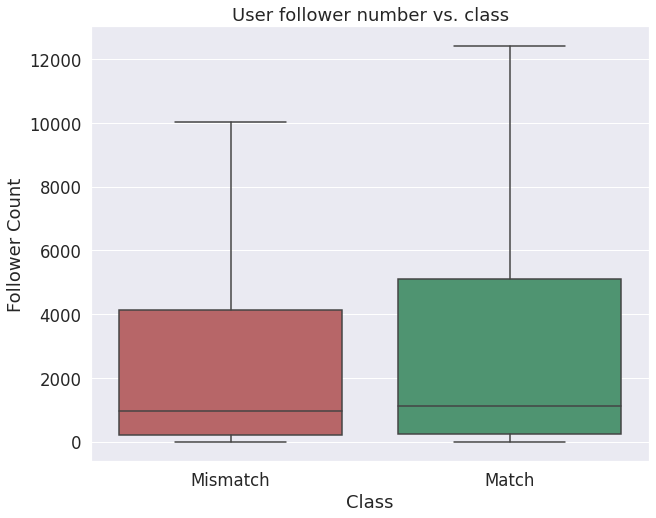

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='user_follower_count',data=df, palette=customPalette, showfliers=False)
plt.title("User follower number vs. class")
plt.xlabel('Class')
plt.ylabel('Follower Count')
plt.xticks([0, 1], ['Mismatch', 'Match'])

### User following count vs. Class

([<matplotlib.axis.XTick at 0x7f5a31b05d90>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

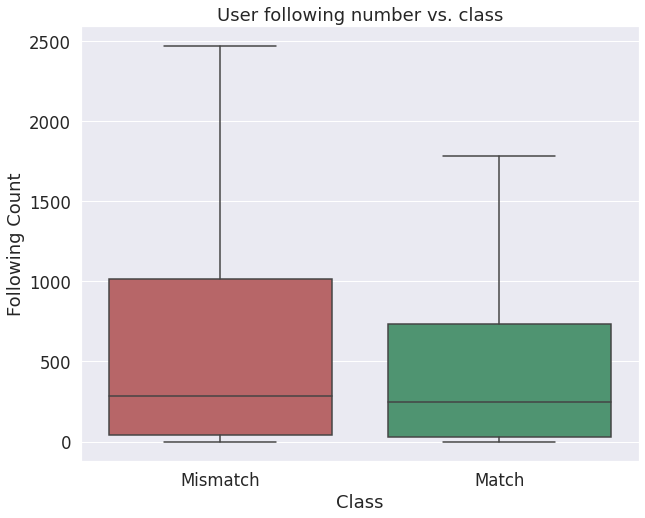

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='user_following_count',data=df, palette=customPalette, showfliers=False)
plt.title("User following number vs. class")
plt.xlabel('Class')
plt.ylabel('Following Count')
plt.xticks([0, 1], ['Mismatch', 'Match'])

### Order of hashtag vs. Class

([<matplotlib.axis.XTick at 0x7f5a31ba2290>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

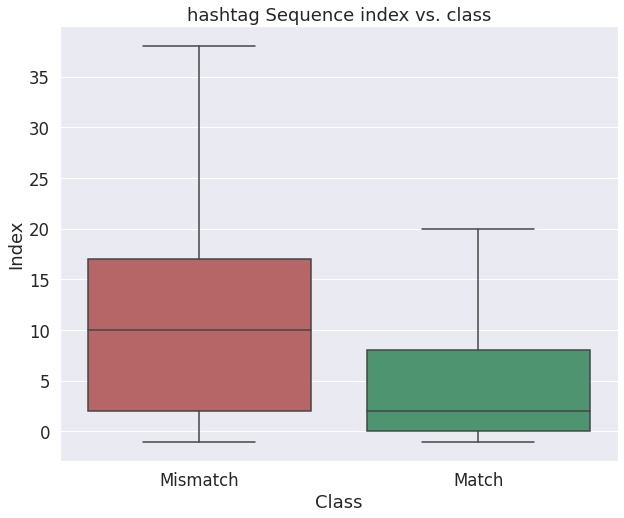

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='hashtag_sequence_num',data=df, palette=customPalette, showfliers=False)
plt.title("hashtag Sequence index vs. class")
plt.xlabel('Class')
plt.ylabel('Index')
plt.xticks([0, 1], ['Mismatch', 'Match'])

### Caption word count vs. Class

([<matplotlib.axis.XTick at 0x7f5a31bbe310>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

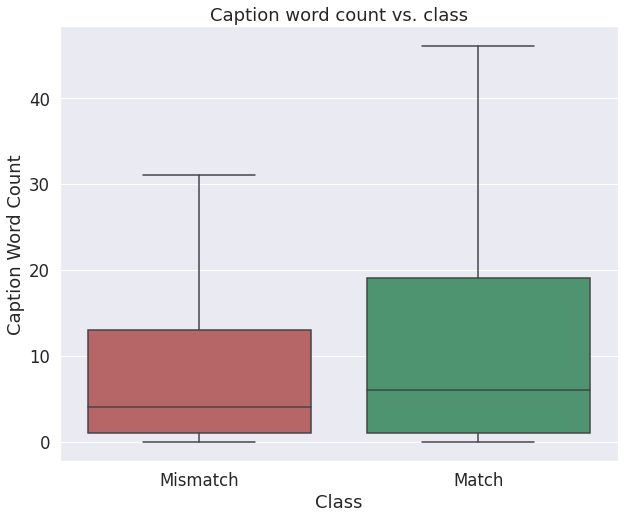

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='capital_char_num',data=df, palette=customPalette, showfliers=False)
plt.title("Caption word count vs. class")
plt.xlabel('Class')
plt.ylabel('Caption Word Count')
plt.xticks([0, 1], ['Mismatch', 'Match'])

### Number of capital character vs. Class

([<matplotlib.axis.XTick at 0x7f5a31c46810>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

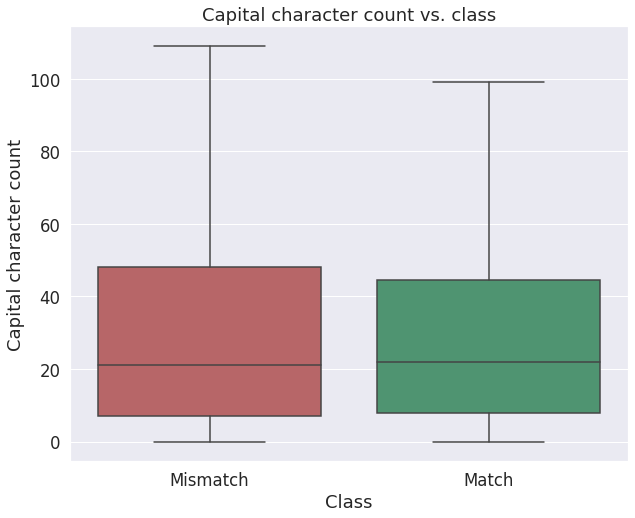

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='text_word_count',data=df, palette=customPalette, showfliers=False)
plt.title("Capital character count vs. class")
plt.xlabel('Class')
plt.ylabel('Capital character count')
plt.xticks([0, 1], ['Mismatch', 'Match'])

### Sentiment vs. Class

([<matplotlib.axis.XTick at 0x7f5a30fed4d0>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

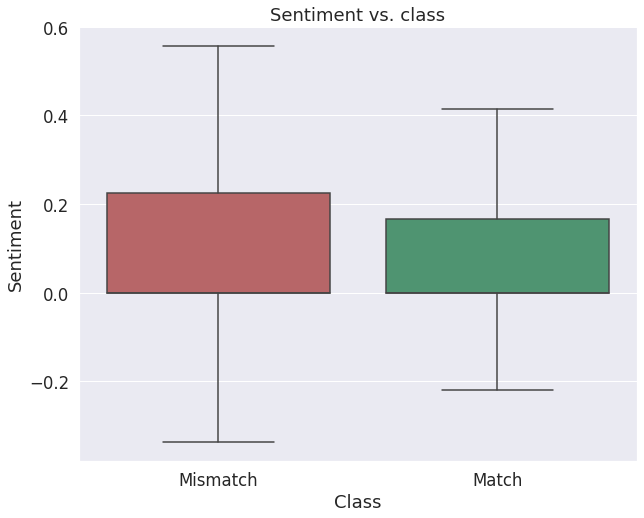

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='sentiment',data=df, palette=customPalette, showfliers=False)
plt.title("Sentiment vs. class")
plt.xlabel('Class')
plt.ylabel('Sentiment')
plt.xticks([0, 1], ['Mismatch', 'Match'])

### Like count vs. Class

([<matplotlib.axis.XTick at 0x7f5a31b6cb10>,
 [Text(0, 0, 'Mismatch'), Text(0, 0, 'Match')])

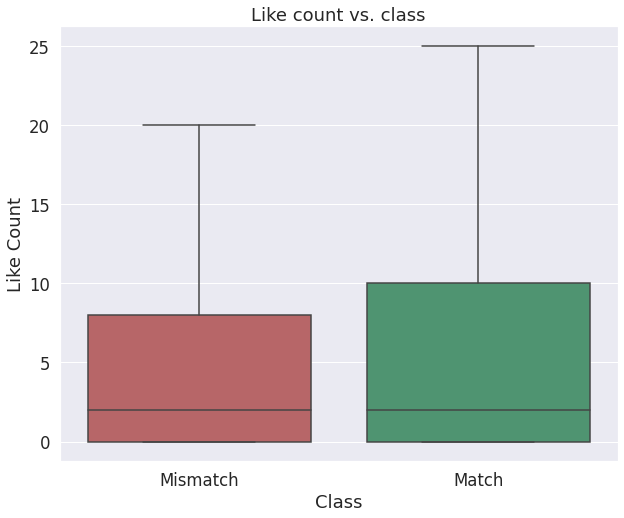

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='class',y='like_count',data=df, palette=customPalette, showfliers=False)
plt.title("Like count vs. class")
plt.xlabel('Class')
plt.ylabel('Like Count')
plt.xticks([0, 1], ['Mismatch', 'Match'])

# Model building

In [ ]:
df_nike = get_dataframe('nike')
df_gucci = get_dataframe('gucci')
df_cristianoronaldo = get_dataframe('cristianoronaldo')
df_edsheeran = get_dataframe('edsheeran')
df = df_nike.append([df_gucci, df_cristianoronaldo, df_edsheeran])

In [ ]:
df.drop(columns=['file_name', 'caption', 'username', 'fullname', 'hashtags',
                 'caption_text_new', 'location_city', 'location_name', 'user_biography',
                 'user_business_category', 'caption_text', 'usertag_list', 
                 'user_is_verified', 'is_bio_related_brand', 'is_username_related_brand',
                 'mention_target_brand', 'tag_other_related_brands', 'user_is_business_account',
                 'is_comment_hashtags', 'has_location', 'hashtag_other_related_brands', 'comment_count',
                 'user_business_category_encoded', 'mention_num', 'image_height', 'digit_num'], inplace=True)

df = df.sample(frac=1)
y = df.iloc[:, 4].values
df2 = df.drop(columns=['class'])
X = df2.iloc[:, :].values
sc_x = StandardScaler()
X_sc = sc_x.fit_transform(X)

## Hyperparameter Tuning

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(units = 128, input_shape=(X.shape[1],), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
    return model

### Batch size & Epoch

In [ ]:
tf.random.set_seed(7)
model = KerasClassifier(model=create_model, verbose=0)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.629970 using {'batch_size': 20, 'epochs': 100}
0.590614 (0.018489) with: {'batch_size': 10, 'epochs': 10}
0.606153 (0.024063) with: {'batch_size': 10, 'epochs': 50}
0.617270 (0.013842) with: {'batch_size': 10, 'epochs': 100}
0.572831 (0.025952) with: {'batch_size': 20, 'epochs': 10}
0.629008 (0.005085) with: {'batch_size': 20, 'epochs': 50}
0.629970 (0.031637) with: {'batch_size': 20, 'epochs': 100}
0.550935 (0.007756) with: {'batch_size': 40, 'epochs': 10}
0.620761 (0.017529) with: {'batch_size': 40, 'epochs': 50}
0.628072 (0.040376) with: {'batch_size': 40, 'epochs': 100}
0.533815 (0.036522) with: {'batch_size': 60, 'epochs': 10}
0.585848 (0.021630) with: {'batch_size': 60, 'epochs': 50}
0.600440 (0.025401) with: {'batch_size': 60, 'epochs': 100}
0.523328 (0.009786) with: {'batch_size': 80, 'epochs': 10}
0.598867 (0.026177) with: {'batch_size': 80, 'epochs': 50}
0.603618 (0.003897) with: {'batch_size': 80, 'epochs': 100}
0.541414 (0.003690) with: {'batch_size': 100, 'epochs':

### Optimizer Algorithms

In [ ]:
model = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=100, batch_size=20, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.620115 using {'optimizer': 'Adam'}
0.606474 (0.020611) with: {'optimizer': 'SGD'}
0.574426 (0.011923) with: {'optimizer': 'RMSprop'}
0.581716 (0.019397) with: {'optimizer': 'Adagrad'}
0.613158 (0.047310) with: {'optimizer': 'Adadelta'}
0.620115 (0.025680) with: {'optimizer': 'Adam'}
0.562998 (0.012281) with: {'optimizer': 'Adamax'}
0.590607 (0.001876) with: {'optimizer': 'Nadam'}


### Learning rate & Momentum

In [ ]:
model = KerasClassifier(model=create_model, loss="binary_crossentropy", optimizer="Adam", epochs=100, batch_size=20, verbose=0)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.642333 using {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.6}
0.582997 (0.052844) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.616628 (0.027892) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.613766 (0.024214) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.579496 (0.006001) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.594094 (0.024601) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
0.593456 (0.020853) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}
0.589982 (0.025153) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}
0.583313 (0.054950) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.590306 (0.038081) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
0.620127 (0.026848) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.591565 (0.015419) w

### Network Weight Initialization

In [ ]:
def create_model(init_mode='uniform'):
 	model = Sequential()
	model.add(Dense(units = 128, input_shape=(X.shape[1],), kernel_initializer=init_mode, activation = 'relu'))
	model.add(Dropout(0.2))
	model.add(Dense(units = 64, activation = 'relu'))
	model.add(Dense(units = 1, activation = 'sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
	return model
	
seed = 7
tf.random.set_seed(seed)
model = KerasClassifier(model=create_model, epochs=100, batch_size=20, verbose=0)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.654395 using {'model__init_mode': 'uniform'}
0.654395 (0.011760) with: {'model__init_mode': 'uniform'}
0.630595 (0.028108) with: {'model__init_mode': 'lecun_uniform'}
0.627733 (0.009126) with: {'model__init_mode': 'normal'}
0.514123 (0.000231) with: {'model__init_mode': 'zero'}
0.636310 (0.012397) with: {'model__init_mode': 'glorot_normal'}
0.615038 (0.015689) with: {'model__init_mode': 'glorot_uniform'}
0.582675 (0.010249) with: {'model__init_mode': 'he_normal'}
0.594723 (0.018838) with: {'model__init_mode': 'he_uniform'}


### Activation Function

In [ ]:
def create_model(init_mode='uniform'):
 	model = Sequential()
	model.add(Dense(units = 128, input_shape=(X.shape[1],), kernel_initializer='uniform', activation = activation))
	model.add(Dropout(0.2))
	model.add(Dense(units = 64, activation = 'relu'))
	model.add(Dense(units = 1, activation = 'sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
	return model

seed = 7
tf.random.set_seed(seed)
model = KerasClassifier(model=create_model, epochs=100, batch_size=20, verbose=0)
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.647099 using {'model__activation': 'linear'}
0.549670 (0.008212) with: {'model__activation': 'softmax'}
0.645514 (0.016646) with: {'model__activation': 'softplus'}
0.592199 (0.020354) with: {'model__activation': 'softsign'}
0.639802 (0.019289) with: {'model__activation': 'relu'}
0.573471 (0.012873) with: {'model__activation': 'tanh'}
0.596319 (0.006628) with: {'model__activation': 'sigmoid'}
0.570938 (0.018352) with: {'model__activation': 'hard_sigmoid'}
0.647099 (0.007433) with: {'model__activation': 'linear'}


### Dropout

In [ ]:
def create_model(dropout_rate, weight_constraint):
 	model = Sequential()
	model.add(Dense(units = 128, input_shape=(X.shape[1],), kernel_initializer='uniform', activation = 'linear', kernel_constraint=MaxNorm(weight_constraint)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(units = 64, activation = 'relu'))
	model.add(Dense(units = 1, activation = 'sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
	return model

seed = 7
tf.random.set_seed(seed)
model = KerasClassifier(model=create_model, epochs=100, batch_size=20, verbose=0)
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.657255 using {'model__dropout_rate': 0.2, 'model__weight_constraint': 3.0}
0.560774 (0.009116) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.649320 (0.007864) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.617902 (0.012947) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.644559 (0.002981) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 4.0}
0.650273 (0.013615) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}
0.617584 (0.036566) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.637902 (0.021729) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.645194 (0.009839) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 3.0}
0.637253 (0.012301) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 4.0}
0.655032 (0.008291) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 5.0}
0.610283 (0.012090) with: {'model__dr

### Number of neurons

In [ ]:
def create_model(neurons):
 	model = Sequential()
	model.add(Dense(128, input_shape=(X.shape[1],), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(3)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(units = neurons, activation = 'relu'))
	model.add(Dense(units = 1, activation = 'sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
	return model

seed = 7
tf.random.set_seed(seed)
model = KerasClassifier(model=create_model, epochs=100, batch_size=20, verbose=0)
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.651544 using {'model__neurons': 30}
0.590915 (0.054431) with: {'model__neurons': 1}
0.642021 (0.018463) with: {'model__neurons': 5}
0.636304 (0.020907) with: {'model__neurons': 10}
0.626793 (0.016879) with: {'model__neurons': 15}
0.578534 (0.070719) with: {'model__neurons': 20}
0.633776 (0.025614) with: {'model__neurons': 25}
0.651544 (0.014456) with: {'model__neurons': 30}


In [ ]:
batch_size = 20
epochs = 100
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
init_mode = 'uniform'
activation = 'linear'
weight_constraint = 3.0
dropout_rate = 0.0
neurons = 30

## Model training

### All hashtags

In [ ]:
y = df.iloc[:, 4].values
df2 = df.drop(columns=['class'])
X = df2.iloc[:, :].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_val = sc_x.transform(x_val)
x_test = sc_x.transform(x_test)

model = Sequential()
model.add(Dense(128, input_shape=(X.shape[1],), kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
model.add(Dropout(0.2))
model.add(Dense(units = neurons, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]


model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = batch_size, epochs = epochs, callbacks=my_callbacks)

Epoch 1/100
285/285 [==============================] - 2s 3ms/step - loss: 0.5979 - accuracy: 0.6834 - val_loss: 0.5895 - val_accuracy: 0.6914
Epoch 2/100
285/285 [==============================] - 1s 2ms/step - loss: 0.5743 - accuracy: 0.7011 - val_loss: 0.5800 - val_accuracy: 0.7073
Epoch 3/100
285/285 [==============================] - 1s 2ms/step - loss: 0.5647 - accuracy: 0.7131 - val_loss: 0.5759 - val_accuracy: 0.6957
Epoch 4/100
285/285 [==============================] - 1s 2ms/step - loss: 0.5539 - accuracy: 0.7187 - val_loss: 0.5747 - val_accuracy: 0.6944
Epoch 5/100
285/285 [==============================] - 1s 2ms/step - loss: 0.5511 - accuracy: 0.7215 - val_loss: 0.5708 - val_accuracy: 0.7023
Epoch 6/100
285/285 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7254 - val_loss: 0.5708 - val_accuracy: 0.7059
Epoch 7/100
285/285 [==============================] - 1s 2ms/step - loss: 0.5437 - accuracy: 0.7300 - val_loss: 0.5666 - val_accuracy: 0.7066

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
y_predict = model.predict(x_test)
y_predict = np.where(y_predict > 0.5, 1, 0)
accuracy = evaluate(y_test, y_predict)

Accuracy score: 0.7550


### Nike

In [ ]:
df_nike.drop(columns=['file_name', 'caption', 'username', 'fullname', 'hashtags',
                 'caption_text_new', 'location_city', 'location_name', 'user_biography',
                 'user_business_category', 'caption_text', 'usertag_list', 
                 'user_is_verified', 'is_bio_related_brand', 'is_username_related_brand',
                 'mention_target_brand', 'tag_other_related_brands', 'user_is_business_account',
                 'is_comment_hashtags', 'has_location', 'hashtag_other_related_brands', 'comment_count',
                 'user_business_category_encoded', 'mention_num', 'image_height', 'digit_num'], inplace=True)

y = df_nike.iloc[:, 4].values
df_nike2 = df_nike.drop(columns=['class'])
X = df_nike2.iloc[:, :].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_val = sc_x.transform(x_val)
x_test = sc_x.transform(x_test)

model2 = Sequential()
model2.add(Dense(128, input_shape=(X.shape[1],), kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
model2.add(Dropout(0.2))
model2.add(Dense(units = neurons, activation = 'relu'))
model2.add(Dense(units = 1, activation = 'sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]


model2.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = batch_size, epochs = epochs, callbacks=my_callbacks)

Epoch 1/100
74/74 [==============================] - 1s 6ms/step - loss: 0.6427 - accuracy: 0.6344 - val_loss: 0.5988 - val_accuracy: 0.6701
Epoch 2/100
74/74 [==============================] - 0s 4ms/step - loss: 0.6024 - accuracy: 0.6868 - val_loss: 0.5878 - val_accuracy: 0.6751
Epoch 3/100
74/74 [==============================] - 0s 5ms/step - loss: 0.5871 - accuracy: 0.6873 - val_loss: 0.5810 - val_accuracy: 0.6751
Epoch 4/100
74/74 [==============================] - 1s 8ms/step - loss: 0.5789 - accuracy: 0.7059 - val_loss: 0.5823 - val_accuracy: 0.6739
Epoch 5/100
74/74 [==============================] - 1s 7ms/step - loss: 0.5696 - accuracy: 0.7050 - val_loss: 0.5918 - val_accuracy: 0.6739
Epoch 6/100
74/74 [==============================] - 1s 7ms/step - loss: 0.5677 - accuracy: 0.7088 - val_loss: 0.5780 - val_accuracy: 0.6891
Epoch 7/100
74/74 [==============================] - 0s 5ms/step - loss: 0.5623 - accuracy: 0.7131 - val_loss: 0.5795 - val_accuracy: 0.6751
Epoch 8/100
7

In [ ]:
model2 = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
y_predict = model2.predict(x_test)
y_predict = np.where(y_predict > 0.5, 1, 0)
accuracy = evaluate(y_test, y_predict)

Accuracy score: 0.7022


### Ed sheeran

In [ ]:
df_edsheeran.drop(columns=['file_name', 'caption', 'username', 'fullname', 'hashtags',
                 'caption_text_new', 'location_city', 'location_name', 'user_biography',
                 'user_business_category', 'caption_text', 'usertag_list', 
                 'user_is_verified', 'is_bio_related_brand', 'is_username_related_brand',
                 'mention_target_brand', 'tag_other_related_brands', 'user_is_business_account',
                 'is_comment_hashtags', 'has_location', 'hashtag_other_related_brands', 'comment_count',
                 'user_business_category_encoded', 'mention_num', 'image_height', 'digit_num'], inplace=True)

y = df_edsheeran.iloc[:, 4].values
df_edsheeran2 = df_edsheeran.drop(columns=['class'])
X = df_edsheeran2.iloc[:, :].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_val = sc_x.transform(x_val)
x_test = sc_x.transform(x_test)

model3 = Sequential()
model3.add(Dense(128, input_shape=(X.shape[1],), kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
model3.add(Dropout(0.2))
model3.add(Dense(units = neurons, activation = 'relu'))
model3.add(Dense(units = 1, activation = 'sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]

model3.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = batch_size, epochs = epochs, callbacks=my_callbacks)

Epoch 1/100
87/87 [==============================] - 2s 6ms/step - loss: 0.5808 - accuracy: 0.7140 - val_loss: 0.5595 - val_accuracy: 0.7229
Epoch 2/100
87/87 [==============================] - 1s 4ms/step - loss: 0.5578 - accuracy: 0.7314 - val_loss: 0.5569 - val_accuracy: 0.7229
Epoch 3/100
87/87 [==============================] - 1s 4ms/step - loss: 0.5531 - accuracy: 0.7360 - val_loss: 0.5577 - val_accuracy: 0.7229
Epoch 4/100
87/87 [==============================] - 1s 5ms/step - loss: 0.5499 - accuracy: 0.7402 - val_loss: 0.5550 - val_accuracy: 0.7197
Epoch 5/100
87/87 [==============================] - 1s 4ms/step - loss: 0.5487 - accuracy: 0.7399 - val_loss: 0.5547 - val_accuracy: 0.7197
Epoch 6/100
87/87 [==============================] - 1s 4ms/step - loss: 0.5478 - accuracy: 0.7406 - val_loss: 0.5531 - val_accuracy: 0.7197
Epoch 7/100
87/87 [==============================] - 1s 4ms/step - loss: 0.5464 - accuracy: 0.7395 - val_loss: 0.5524 - val_accuracy: 0.7197
Epoch 8/100
8

In [ ]:
model3 = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
y_predict = model3.predict(x_test)
y_predict = np.where(y_predict > 0.5, 1, 0)
accuracy = evaluate(y_test, y_predict)

Accuracy score: 0.7478


### Gucci

In [ ]:
df_gucci.drop(columns=['file_name', 'caption', 'username', 'fullname', 'hashtags',
                 'caption_text_new', 'location_city', 'location_name', 'user_biography',
                 'user_business_category', 'caption_text', 'usertag_list', 
                 'user_is_verified', 'is_bio_related_brand', 'is_username_related_brand',
                 'mention_target_brand', 'tag_other_related_brands', 'user_is_business_account',
                 'is_comment_hashtags', 'has_location', 'hashtag_other_related_brands', 'comment_count',
                 'user_business_category_encoded', 'mention_num', 'image_height', 'digit_num'], inplace=True)

y = df_gucci.iloc[:, 4].values
df_gucci2 = df_gucci.drop(columns=['class'])
X = df_gucci2.iloc[:, :].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_val = sc_x.transform(x_val)
x_test = sc_x.transform(x_test)

model4 = Sequential()
model4.add(Dense(128, input_shape=(X.shape[1],), kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
model4.add(Dropout(0.2))
model4.add(Dense(units = neurons, activation = 'relu'))
model4.add(Dense(units = 1, activation = 'sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]

model4.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = batch_size, epochs = epochs, callbacks=my_callbacks)

Epoch 1/100
136/136 [==============================] - 2s 6ms/step - loss: 0.5931 - accuracy: 0.6886 - val_loss: 0.5913 - val_accuracy: 0.6645
Epoch 2/100
136/136 [==============================] - 1s 4ms/step - loss: 0.5688 - accuracy: 0.7011 - val_loss: 0.5903 - val_accuracy: 0.6777
Epoch 3/100
136/136 [==============================] - 1s 7ms/step - loss: 0.5660 - accuracy: 0.7056 - val_loss: 0.5884 - val_accuracy: 0.6711
Epoch 4/100
136/136 [==============================] - 1s 6ms/step - loss: 0.5647 - accuracy: 0.7056 - val_loss: 0.5886 - val_accuracy: 0.6711
Epoch 5/100
136/136 [==============================] - 1s 7ms/step - loss: 0.5638 - accuracy: 0.7048 - val_loss: 0.5896 - val_accuracy: 0.6844
Epoch 6/100
136/136 [==============================] - 1s 9ms/step - loss: 0.5637 - accuracy: 0.7085 - val_loss: 0.5874 - val_accuracy: 0.6777
Epoch 7/100
136/136 [==============================] - 1s 4ms/step - loss: 0.5627 - accuracy: 0.7048 - val_loss: 0.5880 - val_accuracy: 0.6777

In [ ]:
model4 = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
y_predict = model4.predict(x_test)
y_predict = np.where(y_predict > 0.5, 1, 0)
accuracy = evaluate(y_test, y_predict)

Accuracy score: 0.7164


### CristianoRonaldo

In [ ]:
df_cristianoronaldo.drop(columns=['file_name', 'caption', 'username', 'fullname', 'hashtags',
                 'caption_text_new', 'location_city', 'location_name', 'user_biography',
                 'user_business_category', 'caption_text', 'usertag_list', 
                 'user_is_verified', 'is_bio_related_brand', 'is_username_related_brand',
                 'mention_target_brand', 'tag_other_related_brands', 'user_is_business_account',
                 'is_comment_hashtags', 'has_location', 'hashtag_other_related_brands', 'comment_count',
                 'user_business_category_encoded', 'mention_num', 'image_height', 'digit_num'], inplace=True)

y = df_cristianoronaldo.iloc[:, 4].values
df_cristianoronaldo2 = df_cristianoronaldo.drop(columns=['class'])
X = df_cristianoronaldo2.iloc[:, :].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_val = sc_x.transform(x_val)
x_test = sc_x.transform(x_test)

model5 = Sequential()
model5.add(Dense(128, input_shape=(X.shape[1],), kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
model5.add(Dropout(0.2))
model5.add(Dense(units = neurons, activation = 'relu'))
model5.add(Dense(units = 1, activation = 'sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]

model5.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = batch_size, epochs = epochscallbacks=my_callbacks)

Epoch 1/100
141/141 [==============================] - 14s 91ms/step - loss: 0.5807 - accuracy: 0.7168 - val_loss: 0.5769 - val_accuracy: 0.7038
Epoch 2/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5490 - accuracy: 0.7317 - val_loss: 0.5675 - val_accuracy: 0.7197
Epoch 3/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5455 - accuracy: 0.7363 - val_loss: 0.5650 - val_accuracy: 0.7325
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5428 - accuracy: 0.7410 - val_loss: 0.5616 - val_accuracy: 0.7261
Epoch 5/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5414 - accuracy: 0.7441 - val_loss: 0.5601 - val_accuracy: 0.7357
Epoch 6/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5392 - accuracy: 0.7417 - val_loss: 0.5588 - val_accuracy: 0.7293
Epoch 7/100
141/141 [==============================] - 1s 8ms/step - loss: 0.5381 - accuracy: 0.7388 - val_loss: 0.5592 - val_accuracy: 0.72

In [ ]:
model5 = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
y_predict = model5.predict(x_test)
y_predict = np.where(y_predict > 0.5, 1, 0)
accuracy = evaluate(y_test, y_predict)

Accuracy score: 0.7249
